# Duffing Oscillator Reachability Analysis Example

This example demonstrates a complete workflow for reachability verification analysis using the Duffing oscillator system.

| Item                             | Description                                                                                                                                                                                                                                    |
| -------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Dynamical System**             | Duffing Oscillator                                                                                                                                                                                                                             |
| **Dimension**                    | 2D                                                                                                                                                                                                                                             |
| **Expected Verification Result** | Reachable                                                                                                                                                                                                                                      |
| **Eigenpairs**                   | Principal eigenpairs with feasible residuals                                                                                                                                                                                                   |
| **Experiment Objective**         | Extract the system's eigenfunctions through the Residual Dynamic Mode Decomposition (ResDMD) algorithm, and perform reachability bound computation based on these eigenfunctions to verify reachability from the initial set to the target set |
| **Remark**                       | This script obtains data from single domain of attractor                                                                                                                                                                                       |


In [11]:
# load the modules

import os
import sys

sys.path.append("../")

import numpy as np

import ddrv

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


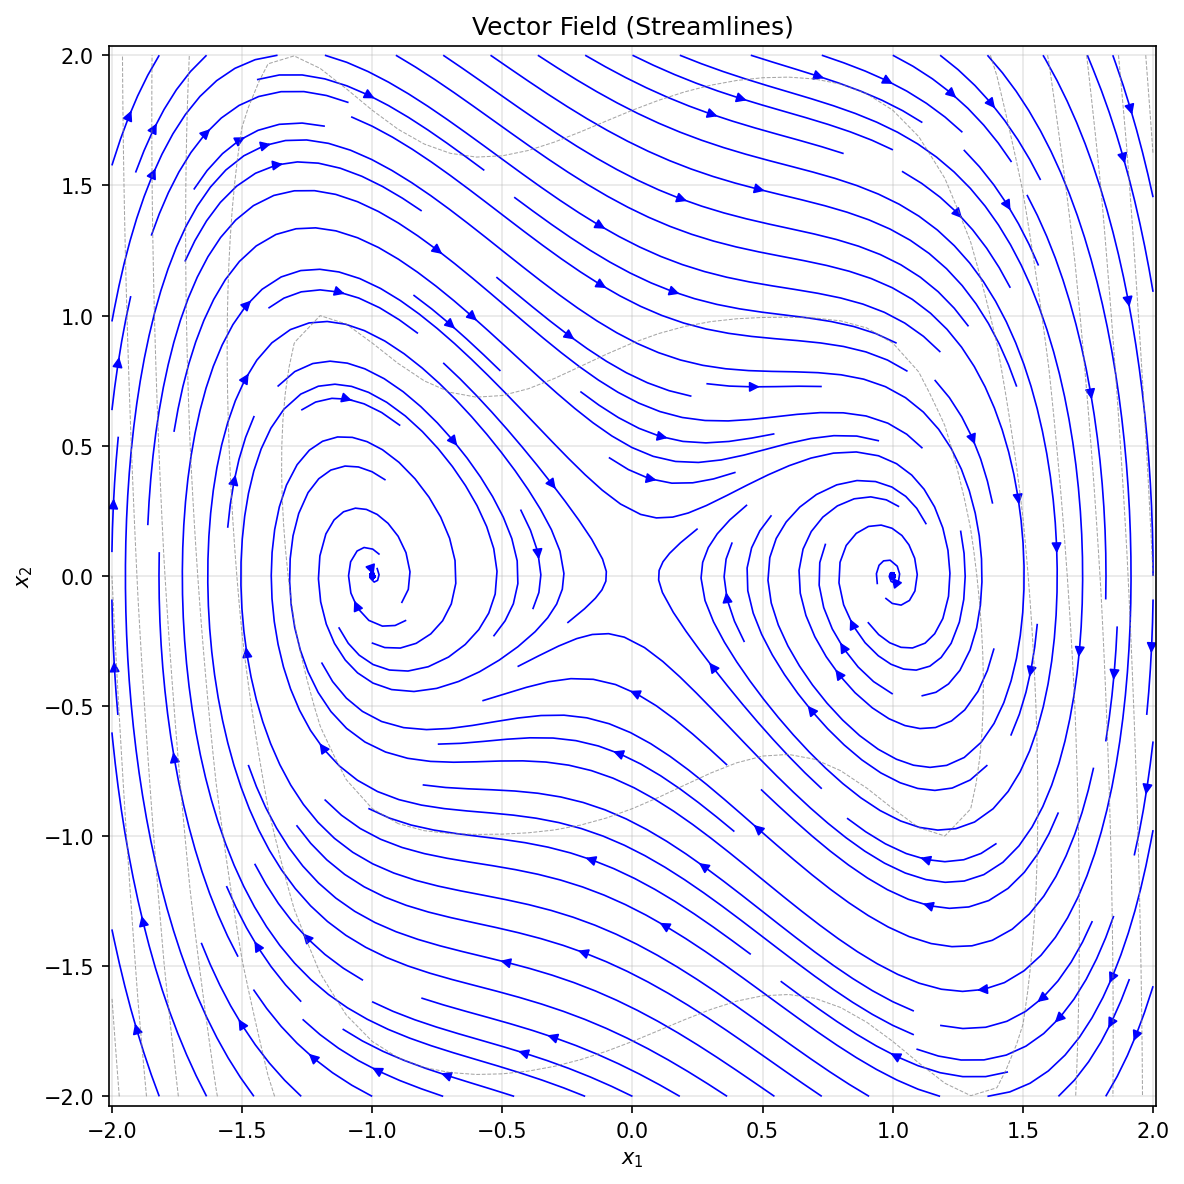

(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'center': 'Vector Field (Streamlines)'}, xlabel='$x_1$', ylabel='$x_2$'>)

In [12]:
# define the dynamical system
duffing_oscillator = ddrv.dynamic.DuffingOscillator()
ddrv.viz.vis_vector_field_2d(
    duffing_oscillator.get_numerical_dynamics(),
    domain=[[-2, 2], [-2, 2]],
    step_size=0.1,
)

generated 1000 trajectories in batch (odeint), 100 steps, 0.03 time step...
(101, 1000, 2)


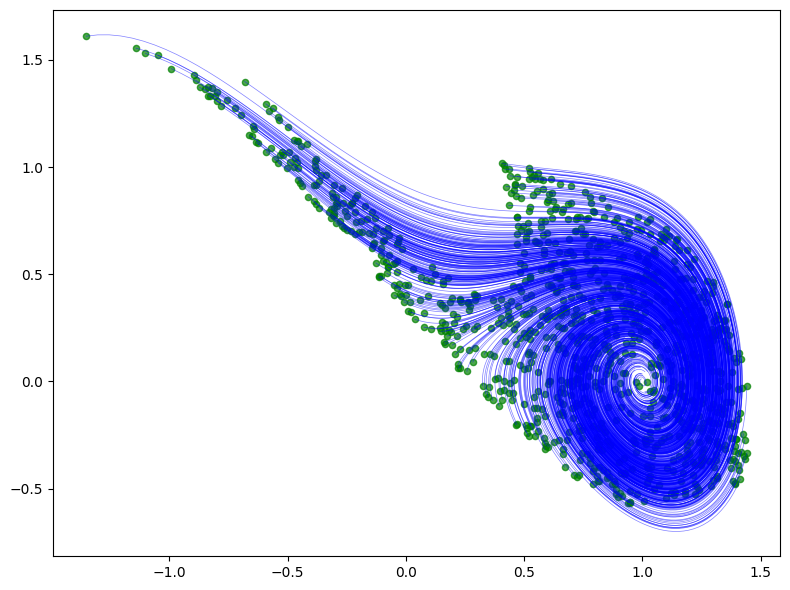

In [13]:
# set the seed for reproducibility
RANDOM_SEED = 0
DT = 0.03

# generate the backward trajectory data
traj_data = ddrv.common.generate_trajectory_data(
    duffing_oscillator,
    domain=[[0.7, 1.3], [-0.3, 0.3]],
    num_samples=1000,
    num_steps=100,
    dt=DT,
    forward=False,
    random_seed=RANDOM_SEED,
)
print(traj_data.shape)
# flip the backward trajectory data to forward
traj_data = traj_data[::-1, :, :]

# visualize the trajectory data
ddrv.viz.vis_trajectory_2d(traj_data)
# now the trajectory data is only from the domain of one specific attractor

In [14]:
# now split the trajectory data into X and Y arrays, X refers the current state, Y refers the next state
X = traj_data[:-1, :, :].reshape(-1, 2)
Y = traj_data[1:, :, :].reshape(-1, 2)
print(X.shape, Y.shape)

(100000, 2) (100000, 2)


In [15]:
LAM_P_ct = [-0.25 + 1.39194109j, -0.25 - 1.39194109j]  # ground truth

In [16]:
# get the principal eigenmodes
principal_eigenmodes, observables, residuals = ddrv.common.get_principal_eigenmodes(
    X,
    Y,
    LAM_P_ct,
    DT,
    observe_params={"basis": "poly", "degree": 15},
)

[-0.2493201+1.39128984j -0.2493201-1.39128984j] L_ct[principal_idx]


In [ ]:
# now with these obtained principal eigenmodes, we can perform reachability verification

# define the initial set, and target set for reachability verification
# X0 = [
#     [-0.8, -0.7],
#     [1.8, 1.9],
# ]  # CAUTION: for this X0, the reachability verification will fail
# X0 = [[0.9, 1.0], [-0.7, -0.6]]


# >>>>> one setting that works <<<<<
# X0 = [[1.4, 1.6], [0.5, 0.7]]
# XF = [[0.6, 0.7], [0.2, 0.3]]

# >>>>> another setting that works <<<<<
# X0 = [[1.0, 1.1], [1.0, 1.1]]
# XF = [[0.6, 0.7], [0.2, 0.3]]

# >>>>> another setting that works <<<<<
X0 = [[0.6, 0.7], [1.1, 1.2]]
XF = [[0.6, 0.7], [0.2, 0.3]]

# >>>>> another setting that works <<<<<
# works, but not that good
# X0 = [[0, 0.1], [1.3, 1.4]]
# XF = [[0.6, 0.7], [0.2, 0.3]]


pts_X0 = ddrv.common.sample_box_set(X0, 5000)
pts_XF = ddrv.common.sample_box_set(XF, 5000)
print(pts_X0.shape, pts_XF.shape)

# evaluate the eigenfunctions on the initial set and target set samples
ef0_vals = observables.eval_mod(pts_X0, principal_eigenmodes)
efF_vals = observables.eval_mod(pts_XF, principal_eigenmodes)
print(ef0_vals.shape, efF_vals.shape)

# compute the reach time bounds
time_bounds, status = ddrv.algo.compute_reach_time_bounds(ef0_vals, efF_vals, LAM_P_ct)
print(time_bounds, status, "time_bounds & status")

(5000, 2) (5000, 2)
(5000, 2) (5000, 2)
[np.float64(-0.6008685423052995),np.float64(4.343934299503658)] bound_mag
[(0, np.float64(0.07916334214226532)), (np.float64(3.9047017084510385), np.float64(4.343934299503658))] ('PROBABLY REACHABLE', 2) time_bounds & status


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


finshed simulation


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


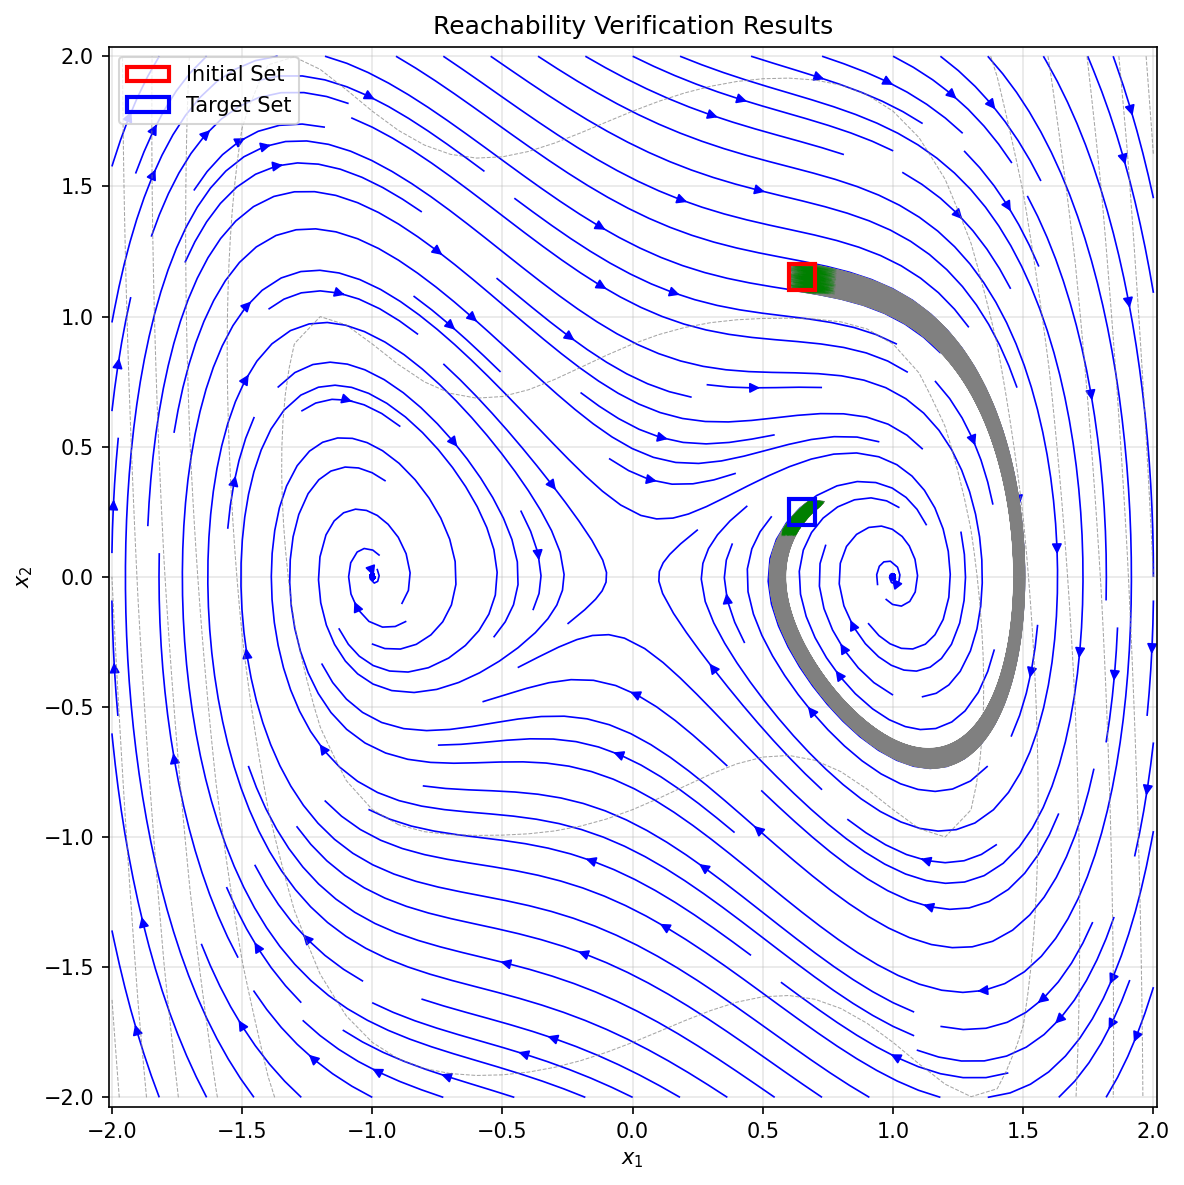

In [18]:
# visualize the reachability result
ddrv.viz.vis_rv(
    duffing_oscillator.get_numerical_dynamics(),
    domain=[[-2, 2], [-2, 2]],
    bounds=time_bounds,
    dt=0.01,
    initial_set=X0,
    target_set=XF,
)